$ \theta = \{\psi, \sigma \} $

$\psi$: Parametros para definição do modelo que será utilizado em cada estado<br>
$\sigma$: Parametros para cada Modelo $\{\sigma_1, \sigma_2, ...\}$ <br>

$ \beta: S \mapsto [0,1]^k \;\; onde \;\; k = |\sigma|$ <br>
$ \beta(s; \psi)_i = p_{\psi}(\sigma_i | s) \; \forall \; i \in (1, 2, ..., k)$ <br>
A função $ \beta $ define a probabilidade de cada parametro em $ \sigma $ ser o modelo utilizado pra gerar a transição em um estado <br>

$\mu: S \times S \times A \times \sigma \mapsto [0,1] $ <br>
$\mu(s', s, a, \sigma_x)= p_{\sigma_x}(s'|s,a)$ <br>
A função $ \mu $ define a probabilidade de transição para um estado, dado um par de estado e ação, seguindo o modelo $\sigma_x$ <br>

In [1]:
import numpy as np
import random

force = .5
actions = np.array([(force,0), (-force,0), (0,force), (0,-force)])
theta = [5, (.005,.3)]

goal = [(5, 9), (5, 9)]
bondry = [(-10, 10), (-10, 10)]

def in_region(s, region):
    x, y = s[0]
    (xa, xb), (ya,yb) = region
    return ((xa < x < xb) and (ya < y < yb))

def mu(s, a, p=2):
    acts = actions[a]
    return s + acts + np.random.normal(0, p, 2)

def beta(x,y):
    psi, _ = theta
    return 1*((x**2 + y**2)**(1/2) < psi)

def generate(s0, n, policy=None):   
    _, sigma = theta
    s = s0
    i = 0
    end = False
    
    while not end:
        if policy is None:
            a = np.random.choice(4, 1)[0]
        else:
            disc_s = policy.discretize_state(s)
            a = np.argmax(policy.Q[disc_s])
            
        m = beta(s[:,0], s[:,1])[0]
        
        if in_region(s, bondry) and i<n and not in_region(s, goal):
            i+=1
            sa = np.insert(s, s.size, a)
            yield np.insert(sa, sa.size, m)
        
            s = mu(s, a, sigma[m])
        else:
            end = True


# def trajectory(s_0=(1,1), n=100):
#     gen = generate(s_0, n)
#     return np.fromiter(gen, dtype=np.dtype((float, 4)))

# s_0 = np.array([[0,0]])
# n = 1000

# O = trajectory(s_0, n)
# O[:] # all
# O[:,0:2] # states
# O[:,2] # actions
# O[:,3] # hidden models


In [2]:
import pandas as pd

def generate_data(trajectory_size=1000, n_trajectories=1, s_0=(0,0), policy=None):
    s_0 = np.array([s_0])
    gen = generate(s_0, 1, policy)
    sx,sy,a,m = next(gen)
    df = pd.DataFrame({
        'n':[0],
        't':[0],
        's':[(sx,sy)],
        'a':[int(a)],
        'm':[int(m)]
        })

    for i in range(n_trajectories):
        gen = generate(s_0, trajectory_size, policy)
        for t,(sx,sy,a,m) in enumerate(gen):
            df.loc[len(df.index)] = [int(i),int(t),(sx,sy),int(a),int(m)]

    df.drop(0, inplace=True)
    return df

df = generate_data() 
df.head()

,n,t,s,a,m
1,0,0,"(0, 0)",3,1
2,0,1,"(0.3739149042950822, -0.5825824347660749)",1,1
3,0,2,"(-0.2686998638865852, -0.7475171273693764)",3,1
4,0,3,"(-0.8111123702735467, -1.4756632056865764)",3,1
5,0,4,"(-0.997622961199713, -2.134386477032392)",1,1


<AxesSubplot: >

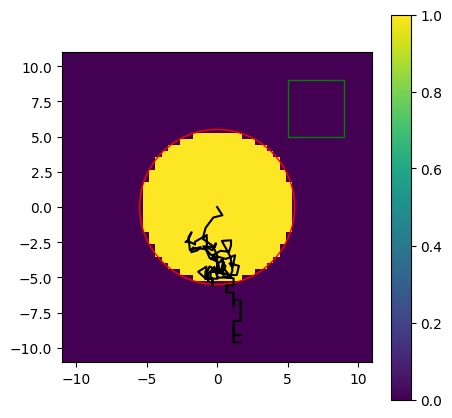

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle

def plot_trajectory(data, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    # ax.invert_yaxis()

    size = 10
    res = 50
    x = np.linspace(-size, size, res).reshape(-1,1)
    y = np.linspace(-size, size, res).reshape(-1,1)

    X,Y = np.meshgrid(x,y)
    p = ax.imshow(beta(X,Y), extent=(int(min(x))-1, int(max(x))+1, int(max(y))+1, int(min(y))-1), vmin = 0, vmax = 1)
    plt.colorbar(p)
    ax.invert_yaxis()

    diff = lambda a,b: b-a

    df_s = pd.DataFrame(data.s.to_list(), columns=['x','y'])
    ax.plot(df_s.x, df_s.y, color='black')
    ax.add_patch(Circle((0, 0), theta[0]+force, edgecolor='red', fill=False))
    ax.add_patch(Rectangle(list(zip(*goal))[0], diff(*goal[0]), diff(*goal[1]), edgecolor='green', fill=False))
    return ax

plot_trajectory(df[df.n==0])

In [4]:
import torch
from torch.autograd import Variable
from torch.distributions import normal
import torch.nn as nn
import torch.nn.functional as f

class BetaModel(nn.Module):
    def __init__(self):
        super(BetaModel, self).__init__()
        n_features = 2
        n_models = 2
        n_hidden = 10

        self.model = nn.Sequential(
            nn.Linear(n_features, n_hidden).double(),
            nn.ReLU(),
            # nn.Linear(n_hidden, n_hidden).double(),
            # nn.ReLU(),
            nn.Linear(n_hidden, n_models).double(),
            nn.ReLU(),
            nn.Softmax(dim=1)
            # nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        return self.model(x)
    
m = BetaModel()

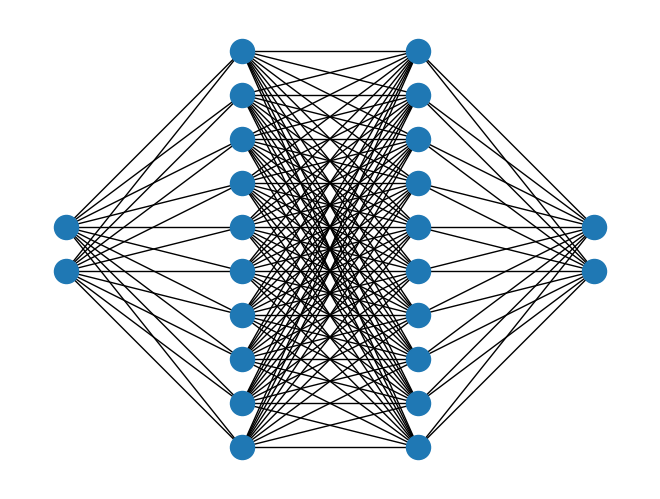

In [5]:
import itertools
import networkx as nx

def draw_model(m):
    subset_color = [
        "gold",
        "darkorange",
        "darkorange",
        "red",
    ]

    def model_graph(m):
        subset_sizes = tuple(np.array([[i.in_features, i.out_features] for i in m.model if type(i) == torch.nn.modules.linear.Linear]).flatten().tolist())
        extents = nx.utils.pairwise(itertools.accumulate((0,) + subset_sizes))
        layers = [range(start, end) for start, end in extents]
        G = nx.Graph()
        for i, layer in enumerate(layers):
            G.add_nodes_from(layer, layer=i)
        for layer1, layer2 in nx.utils.pairwise(layers):
            G.add_edges_from(itertools.product(layer1, layer2))
        return G

    G = model_graph(m)
    # color = [subset_color[data["layer"]] for v, data in G.nodes(data=True)]
    pos = nx.multipartite_layout(G, subset_key="layer")
    nx.draw(G, pos, with_labels=False)

draw_model(m)

In [6]:
def loglike(beta, sigma, data):
    acts = np.stack((
        np.take(actions[:,0], data.a.iloc[:-1]), 
        np.take(actions[:,1], data.a.iloc[:-1])
    ), axis=-1)

    s = torch.from_numpy(data['s'].iloc[:-1].apply(pd.Series).to_numpy()).type(torch.DoubleTensor)
    a = torch.from_numpy(acts).type(torch.DoubleTensor)
    s_ = torch.from_numpy(data['s'].iloc[1:].apply(pd.Series).to_numpy()).type(torch.DoubleTensor)
        
    mi = torch.exp(normal.Normal((s[:,0] + a[:,0]).reshape((-1,1)), torch.exp(sigma)).log_prob(s_[:,0].reshape((-1,1)))) * torch.exp(normal.Normal((s[:,1] + a[:,1]).reshape((-1,1)), torch.exp(sigma)).log_prob(s_[:,1].reshape((-1,1))))

    p_theta = torch.sum((mi * beta), 1) 

    return -torch.sum(torch.log(p_theta))


# df_teste = df.loc[df.n==0].iloc[:-1].copy()
# df_teste['m2'] = 1-df_teste.m
# loglike(torch.from_numpy(df_teste[['m2', 'm']].to_numpy()), df.loc[df.n==0])


In [7]:

def train(model, sigma, data, epochs=1000, log=False):
    x_train_tensor = torch.tensor(data['s'].iloc[:-1].apply(pd.Series).to_numpy()).type(torch.DoubleTensor)
    # sigma = Variable(torch.rand(2)).type(torch.DoubleTensor)
    # sigma = torch.nn.Parameter(torch.rand(2).type(torch.DoubleTensor))

    optim = torch.optim.SGD(list(model.parameters()) + [sigma], lr=1e-4, momentum=.9)
    loss = loglike

    def do_train(epoch):
        optim.zero_grad()
        outputs = model(x_train_tensor)

        ll = loss(outputs, sigma, data)
        if log:
            print(epoch, ll.item(), torch.exp(sigma))
        ll.backward()
        optim.step() 
        return ll.item()

    model.train(True)
    lls = [do_train(epoch) for epoch in range(epochs)]
    model.train(False)

    return lls


# torch.manual_seed(0)
# log = True
# # log = False
# def train_models(data, n_models=10):
#     params = lambda : torch.nn.Parameter(torch.rand(2).type(torch.DoubleTensor))
#     models = [(BetaModel(), params()) for _ in range(n_models)]
#     results = [train(*model, data, epochs=100, log=log) for model in models]
#     return models, results
# mod, res = train_models(df[df.n==0], 1)
# res

In [8]:
def train_models(data, n_models=10):
    params = lambda : torch.nn.Parameter(torch.rand(2).type(torch.DoubleTensor))
    models = [(BetaModel(), params()) for _ in range(n_models)]
    results = [train(*model, data, epochs=200) for model in models]  # com 100 epochs - estimativa de 85min 
    # results = [train(*model, data) for model in models] # com 1000 epochs - estimativa de 8,5h 
    return models, results

n = 1 
m = 1
models = []
results = []
for i in range(n):
    mod, res = train_models(df[df.n==i], m)
    models.append(mod)
    results.append(res)

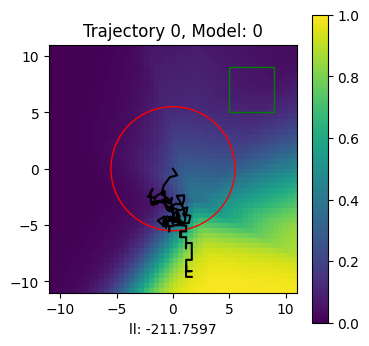

In [110]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def plot_test(data, t=None, n=None):
    if t is None:
        ts = range(len(models))
    else:
        ts = [t]

    if n is None:
        ms = range(len(models[ts[0]]))
    else:
        ms = [n]

    # fig = plt.figure(1, figsize=(5, 5*len(ms)))
    fig, axs = plt.subplots(len(ts), len(ms), figsize=(4*len(ms), (4*len(ts))))
    if len(ts)==1:
        axs = [axs]
    if len(ms)==1:
        axs = [[a] for a in axs]

    
    size = 10
    res = 50
    lin = np.linspace(-size, size, res).reshape(-1,1)
    X,Y = np.meshgrid(lin, lin)

    d = np.stack((X, Y), axis=-1).reshape(-1, 2)
    d = torch.from_numpy(d).type(torch.DoubleTensor)
    
    for row, t in zip(axs, ts):
        df_s = pd.DataFrame(data[data.n==t].s.to_list(), columns=['x','y'])
        
        for ax, m in zip(row, ms):
            ax.set_title(f'Trajectory {t}, Model: {m}')
            corr = models[t][m][0](d)[:,1].reshape(int(X.size**(1/2)), int(X.size**(1/2)))
            with torch.no_grad():
                p = ax.imshow(corr, extent=(int(min(lin))-1, int(max(lin))+1, int(max(lin))+1, int(min(lin))-1), vmin = 0, vmax = 1)
                plt.colorbar(p)
            ax.invert_yaxis()
            ax.set_xlabel(f'll: {results[t][m][-1]:.4f}')
            ax.plot(df_s.x, df_s.y, color='black')
            ax.add_patch(Circle((0, 0), theta[0]+force, edgecolor='red', fill=False))
            diff = lambda a,b: b-a
            ax.add_patch(Rectangle(list(zip(*goal))[0], diff(*goal[0]), diff(*goal[1]), edgecolor='green', fill=False))



plot_test(df)
# plot_test(df, 0)
# plot_test(df, 0,0)

In [116]:
class World:
    def __init__(self, m):
        self.beta, self.params = m

    def transition(self, s,a):
        with torch.no_grad():
            m = np.argmax(self.beta(torch.tensor([list(s)]).type(torch.DoubleTensor))[0])
            p = torch.exp(self.params[m]).item()
            s_ = mu(s, a, p)

            out_bound = not in_region(s_.tolist(), bondry)
            in_goal = in_region(s_.tolist(), goal)
            r = in_goal*1e0 -1 + out_bound* -1e5
            return s_, r, (out_bound or in_goal)
        


In [11]:
def epsilon_greedy(S, Q, e):
    explore = np.random.choice([0,1], p=[e, 1-e])
    return (np.random.randint(0,2), np.argmax(Q[S]))[explore]

In [92]:
from sklearn.preprocessing import KBinsDiscretizer

class Dyna:
    def __init__(self, model, alpha=.3, gamma=.9, epsilon=.2, init_seed=None):
        self.model = model

        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        self.space_state_side = 40 

        if init_seed is None:
            self.Q = np.zeros(shape=[self.space_state_side, self.space_state_side, 4])
        else:
            np.random.seed(init_seed)
            self.Q = np.random.rand(self.space_state_side, self.space_state_side, 4)
        self.data = pd.DataFrame(data={'episode':[], 'step':[], 'S':[], 'A':[], 'R':[]})

    def plot(self, axs=None, type='total_reward'):
        if axs is None:
            _, axs = plt.subplots(1, 1, figsize=(10, 4))

        if type == "total_reward":
            axs.plot(self.data[['episode', 'R']].groupby(['episode']).sum().R)
        if type == "cumulative_reward":
            axs.plot(np.cumsum(self.data[['episode', 'R']].groupby(['episode']).sum().R))
        if type == "moving_avg":
            axs.plot(np.convolve(self.data[['episode', 'R']].groupby(['episode']).sum().R, np.ones(100)/100, mode='valid'))
        if type == "cumulative_avg":
            axs.plot(np.cumsum(self.data[['episode', 'R']].groupby(['episode']).sum().R) / (self.data[['episode', 'R']].groupby(['episode']).sum().reset_index().episode +1))

        return axs

    def discretize_state(self, s):
        # bounds = [[-10, -10], [10, 10]]
        bounds = list(zip(*bondry))

        discretizer = KBinsDiscretizer(n_bins=self.space_state_side, encode='ordinal', strategy='uniform')
        discretizer.fit(bounds)
        discrete_state = discretizer.transform(s)[0]
        return tuple(map(int, discrete_state))

        # return (np.array(s)*100).astype(int)  

    def plan(self, episodes=100, log=False, save=True, seed=0):
        np.random.seed(seed)

        for episode  in range(episodes):
            terminated = False
            step = 0

            s_0 = (0,0)
            observation = np.array([s_0])
            S = self.discretize_state(observation)
            
            if log:
                print(observation)

            data = {'episode': [episode], 'step':[np.nan], 'S':[S], 'A':[np.nan], 'R':[0]}
            while not terminated:
                A = epsilon_greedy(S, self.Q, self.epsilon)
                observation, R, terminated = self.model.transition(observation, A)

                if log:
                    print(observation)

                S_ = self.discretize_state(observation) 

                step += 1

                if log:
                    print(episode, step, S,A,R,S_)
                
                self.Q[(*S, A)] += self.alpha*(R + self.gamma * np.max(self.Q[S_]) - self.Q[(*S, A)])
                S = S_

                data['episode'].append(episode)
                data['step'].append(step)
                data['S'].append(S)
                data['A'].append(int(A))
                data['R'].append(int(R))

            if save:
                self.data = pd.concat([self.data, pd.DataFrame(data=data)], ignore_index=True)


<AxesSubplot: >

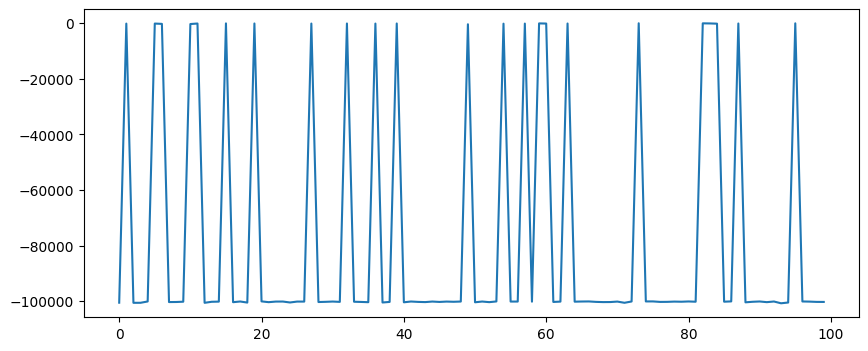

In [117]:
nn_model = World(models[0][0])
my_model = Dyna(nn_model, alpha=.2, gamma=.95, epsilon=.3, init_seed=0)

my_model.plan(episodes=100, log=False)
my_model.plot()

In [118]:
df2 = generate_data(n_trajectories=5, policy=my_model)
df2.head()

,n,t,s,a,m
1,0,0,"(0, 0)",0,1
2,0,1,"(0.8249961746402479, -0.5283883308470997)",3,1
3,0,2,"(0.780647858664951, -1.293649692382553)",1,1
4,0,3,"(0.28169663393823435, -1.2395150348901016)",3,1
5,0,4,"(-0.06592503866517896, -1.8425839905952488)",1,1


<AxesSubplot: >

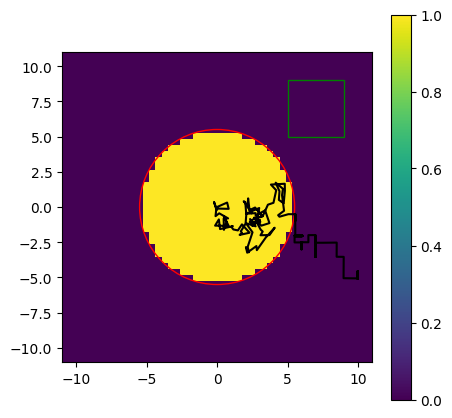

In [126]:
plot_trajectory(df2[df2.n==3])

In [120]:
df2[df2.n==0]

,n,t,s,a,m
1,0,0,"(0, 0)",0,1
2,0,1,"(0.8249961746402479, -0.5283883308470997)",3,1
3,0,2,"(0.780647858664951, -1.293649692382553)",1,1
4,0,3,"(0.28169663393823435, -1.2395150348901016)",3,1
5,0,4,"(-0.06592503866517896, -1.8425839905952488)",1,1
...,...,...,...,...,...
996,0,995,"(-4.732172209587262, -5.414753998868307)",2,0
997,0,996,"(-4.732046565485514, -4.913429698866755)",3,0
998,0,997,"(-4.736839666098072, -5.419116048368753)",2,0
999,0,998,"(-4.737266231912272, -4.915765006094263)",3,0


In [121]:
i = 2
print(np.array([df2[df2.n==4].s.iloc[i]]))
print(my_model.discretize_state(np.array([df2[df2.n==4].s.iloc[i]])))

[[0.72254789 0.43216051]]
(21, 20)
